In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import pandas as pd
from planet_cookbook import read_reports as rr
import os
import rebound
import seaborn as sns

sol_to_earth = 332946.078
G = 6.6743* 10**(-11) #N⋅m2/kg2
M_sun = 1.989e+33 #g
AU = 1.496e+13 #cm

In [3]:
params = {
   'axes.labelsize': 15,
   'font.size': 15,
   'legend.fontsize': 10,
   'xtick.labelsize': 15,
   'ytick.labelsize': 15,
   'text.usetex': True, #to use TeX in your labels
   'font.family':'serif',
   'axes.titlesize': 15
   }
rcParams.update(params)

In [4]:
#Color-blind friendly pallete
colors = [
    "#0C7BDC",  # Vibrant Blue
    "#E66100",  # Bright Orange
    "#40B0A6",  # Teal/Aqua
    "#8B8D8B",  # Medium Grey
    "#5D3A9B"   # Muted Purple
]

vib_blue = "#0C7BDC"
teal = "#40B0A6"
purple = "#5D3A9B" 

In [5]:
solar_system_df = pd.read_csv('solarsystem.csv')
mercury = solar_system_df[solar_system_df['name'] == 'Mercury']
venus = solar_system_df[solar_system_df['name'] == 'Venus']
earth = solar_system_df[solar_system_df['name'] == 'Earth']
mars = solar_system_df[solar_system_df['name'] == 'Mars']

# 1) Read runtime data to see which simulations we need to keep

In [6]:
base_path = "/Users/honeyeah/Codes/data/" #folder with all data

sim_set = "ueda_v3/" #name of simulation set, folder with subfolders the name "sim_set_i"
sim_archive_path = base_path + sim_set + "ueda_v3_" #path given to get_runtime_data function
ueda_v3_rdf = rr.get_runtime_data(sim_archive_path, 35, "ueda_v3_") #rdf is runtime data frame

sim_set = "cham_bench/" #name of simulation set, folder with subfolders the name "sim_set_i"
sim_archive_path = base_path + sim_set + "cham_bench_" #path given to get_runtime_data function
cham_bench_rdf = rr.get_runtime_data(sim_archive_path, 10, "cham_simarchive_") #rdf is runtime data frame

sim_set = "cham_cont/" #name of simulation set, folder with subfolders the name "sim_set_i"
sim_archive_path = base_path + sim_set + "cham_cont_" #path given to get_runtime_data function
cham_cont_rdf = rr.get_runtime_data(sim_archive_path, 10, "cham_cont_") #rdf is runtime data frame

cut_time = 299.9e6

/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: Run

In [7]:
n_runs_ueda_v3 = 35
n_runs_cham_bench = 10
n_runs_cham_cont = 10

maxtimes_ueda_v3 = np.array([
    ueda_v3_rdf[ueda_v3_rdf['simulation_id'] == i + 1]['time'].max()
    for i in range(n_runs_ueda_v3)
])

maxtimes_cham_bench = np.array([
    cham_bench_rdf[cham_bench_rdf['simulation_id'] == i + 1]['time'].max()
    for i in range(n_runs_cham_bench)
])

maxtimes_cham_cont = np.array([
    cham_cont_rdf[cham_cont_rdf['simulation_id'] == i + 1]['time'].max()
    for i in range(n_runs_cham_bench)
])

keep_ueda_v3 = np.where(maxtimes_ueda_v3 > 299.9e6)[0]
keep_cham_bench = np.where(maxtimes_cham_bench > 299.9e6)[0]
keep_cham_cont = np.where(maxtimes_cham_cont > 299.9e6)[0]

print("number of finished runs\n")
print(f"ueda_v3: {len(keep_ueda_v3)}")
print(f"cham_bench: {len(keep_cham_bench)}")
print(f"cham_cont: {len(keep_cham_cont)}")

number of finished runs

ueda_v3: 29
cham_bench: 10
cham_cont: 6


# Read particle parameters from REBOUND SimulationArchives
# Read planet compositions from COREGIVER outputs

In [8]:
#FOR UEDA V3

ueda_v3_ppdf_list = rr.get_particle_params_at_time(
    f"/Users/honeyeah/Codes/data/ueda_v3/ueda_v3_", keep_ueda_v3, "ueda_v3_", cut_time
)

ueda_v3_pldf_list = []
for j, i in enumerate(keep_ueda_v3):
    if i == 26:
        continue
    df = rr.read_dbct_output(
        f"/Users/honeyeah/Codes/data/ueda_v3/ueda_v3_{i+1}/uniform_33.txt",
        0.3, "none", "none"
    )

    df_len = len(df)
    param_len = len(ueda_v3_ppdf_list[j])

    min_len = min(df_len, param_len)

    if min_len == 0:
        print(f"Skipping index {i}: empty df or param list.")
        continue

    # Trim both to same length
    df = df.iloc[:min_len].copy()
    semi_values = ueda_v3_ppdf_list[j]['semi'][:min_len]
    df['semi'] = semi_values.values  # if semi_values is a Series
    df['sim_id'] = i + 1

    ueda_v3_pldf_list.append(df)


/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: Run

In [9]:
cham_bench_ppdf_list = rr.get_particle_params_at_time(
    f"/Users/honeyeah/Codes/data/cham_bench/cham_bench_", keep_cham_bench, "cham_simarchive_", cut_time
)

cham_bench_pldf_list = []

for j, i in enumerate(keep_cham_bench):
    df = rr.read_dbct_output(
        f"/Users/honeyeah/Codes/data/cham_bench/cham_bench_{i+1}/uniform_33.txt",
        0.3, "none", "none"
    )

    df_len = len(df)
    param_len = len(cham_bench_ppdf_list[j])

    min_len = min(df_len, param_len)

    if min_len == 0:
        print(f"Skipping index {i}: empty df or param list.")
        continue

    # Trim both to same length
    df = df.iloc[:min_len].copy()
    semi_values = cham_bench_ppdf_list[j]['semi'][:min_len]
    df['semi'] = semi_values.values  # if semi_values is a Series
    df['sim_id'] = i + 1

    cham_bench_pldf_list.append(df)


/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: Run

In [10]:
cham_cont_ppdf_list = rr.get_particle_params_at_time(
    f"/Users/honeyeah/Codes/data/cham_cont/cham_cont_", keep_cham_cont, "cham_cont_", cut_time
)

cham_cont_pldf_list = []

for j, i in enumerate(keep_cham_cont):
    df = rr.read_dbct_output(
        f"/Users/honeyeah/Codes/data/cham_cont/cham_cont_{i+1}/uniform_33.txt",
        0.3, "none", "none"
    )

    df_len = len(df)
    param_len = len(cham_cont_ppdf_list[j])

    min_len = min(df_len, param_len)

    if min_len == 0:
        print(f"Skipping index {i}: empty df or param list.")
        continue

    # Trim both to same length
    df = df.iloc[:min_len].copy()
    semi_values = cham_cont_ppdf_list[j]['semi'][:min_len]
    df['semi'] = semi_values.values  # if semi_values is a Series
    df['sim_id'] = i + 1

    cham_cont_pldf_list.append(df)


/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed. Binary file was saved with REBOUND Version 4.4.7. You are currently using REBOUND Version 4.4.8.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/rebound/simulationarchive.py:103: Run

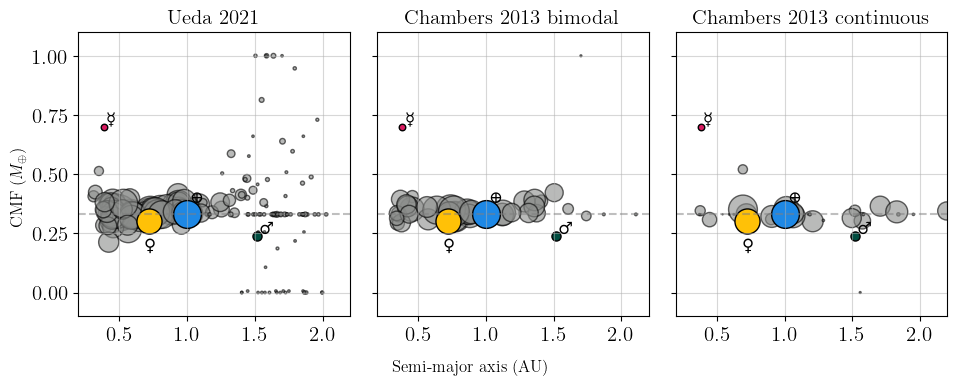

time = 3.00e+08 yrs


In [11]:
ueda_v3_pldf = pd.concat(ueda_v3_pldf_list)
cham_bench_pldf = pd.concat(cham_bench_pldf_list)
cham_cont_pldf = pd.concat(cham_cont_pldf_list)

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, sharex=True)

# Plot configs
datasets = [
    ("Ueda 2021", ueda_v3_pldf, colors[3]),
    ("Chambers 2013 bimodal", cham_bench_pldf, colors[3]),
    ("Chambers 2013 continuous", cham_cont_pldf, colors[3])
]

dot_scale = 400

for ax, (label, df, color) in zip(axes.flat, datasets):
    ax.grid(True, alpha = 0.5)
    ax.plot([0.2, 2.2], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5)

    ax.scatter(df['semi'], df['cmf'], alpha=0.6, color=color,
               edgecolors='black', linewidths=1, s = df['mass'] * sol_to_earth * dot_scale)

    # Add Mercury & Earth
    ax.scatter(0.387, 0.7, color='#D81B60', edgecolors='black', linewidths=1, s= 0.055 * dot_scale, label = 'Mercury')
    ax.annotate('☿', [0.4, 0.71], fontsize=12, usetex=False)

    ax.scatter(0.723, 0.3, color='#FFC107', edgecolors='black', linewidths=1, s=0.815 * dot_scale, label = 'Venus')
    ax.annotate('♀', [0.68, 0.18], fontsize=12, usetex=False)

    ax.scatter(1, 0.33, color='#1E88E5', edgecolors='black', linewidths=1, s=dot_scale, label = 'Earth')
    ax.annotate('⊕', [1.02, 0.38], fontsize=12, usetex=False)

    ax.scatter(1.52, 0.24, color='#004D40', edgecolors='black', linewidths=1, s=0.107 * dot_scale, label = 'Mars')
    ax.annotate('♂', [1.53, 0.25], fontsize=12, usetex=False)

   
    # Reference lines
    #ax.plot([0.35, 2], [0.3, 0.3], linestyle='dashed', color='grey', alpha=0.5)
    #ax.plot([0.35, 0.35], [0.01, 1.2], linestyle='dashed', color='grey', alpha=0.5)
    #ax.plot([0.7, 0.7], [0.01, 1.2], linestyle='dashed', color='grey', alpha=0.5)

    ax.set_xlim(0.2, 2.2)
    ax.set_ylim(-0.1,1.1)
    ax.set_title(label)

#ax.legend(loc = 'upper right')

# Shared axis labels
fig.text(0.5, 0.04, 'Semi-major axis (AU)', ha='center', fontsize=12)
fig.text(0.04, 0.5, r'CMF ($M_\oplus$)', va='center', rotation='vertical', fontsize=12)

#fig.suptitle('Uniform CMF distributions (0.33)')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

plt.savefig("paper_plots/uniform_cmf_dists.pdf", dpi=300)  # or .png

plt.show()

print(f"time = {cut_time:.2e} yrs")
#print("mean max time reached for Ueda v1 = ", np.average(maxtimes_ueda_v1)/1e6, "Myrs")
#print("mean max time reached for Cham = ", np.average(maxtimes_cham_bench)/1e6, "Myrs")

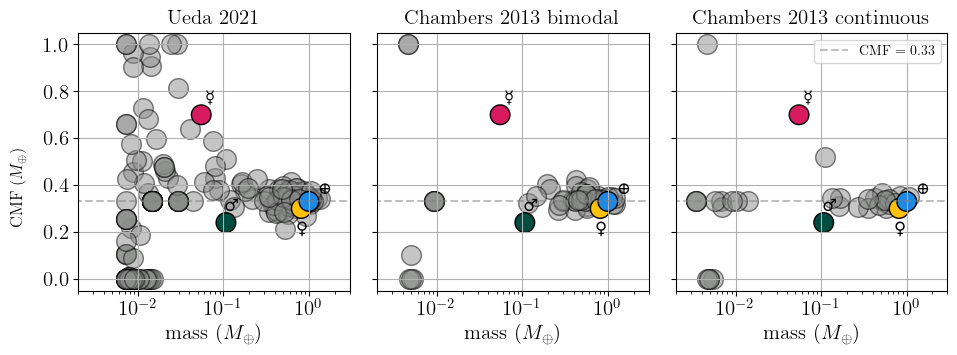

time = 3.00e+08 yrs


In [12]:
fig, axes = plt.subplots(1,3, figsize=(10, 4), sharey=True, sharex=True)
point_size = 200

for ax, (label, df, color) in zip(axes.flat, datasets):
    ax.scatter(df['mass'] * sol_to_earth, df['cmf'], alpha=0.5, color=color, edgecolors='black', linewidths=1, s = point_size)

    # Add solar system planets
    ax.scatter(solar_system_df['m'], solar_system_df['CMF'], color = solar_system_df['color'], edgecolors='black', linewidths=1, s = point_size)
    ax.annotate('☿', [0.06, 0.75], fontsize=12, usetex=False)
    ax.annotate('♀', [0.7, 0.19], fontsize=12, usetex=False)
    ax.annotate('⊕', [1.25, 0.36], fontsize=12, usetex=False)
    ax.annotate('♂', [0.1, 0.29], fontsize=12, usetex=False)

    ax.plot([0.001, 10], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5, label = 'CMF = 0.33')

    ax.set_xscale('log')
    ax.set_xlabel(r'mass ($M_\oplus$)')

    ax.set_xlim(2 * 1e-3, 3)
    ax.grid(True)
    ax.set_title(label)
    

# Shared axis labels
ax.legend()
fig.text(0.04, 0.5, r'CMF ($M_\oplus$)', va='center', rotation='vertical', fontsize=12)

#fig.suptitle('Uniform CMF distributions (0.33)')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

plt.savefig("paper_plots/uniform_m_cmf.pdf", dpi=300)  # or .png

plt.show()

print(f"time = {cut_time:.2e} yrs")
#print("mean max time reached for Ueda v1 = ", np.average(maxtimes_ueda_v1)/1e6, "Myrs")
#print("mean max time reached for Cham = ", np.average(maxtimes_cham_bench)/1e6, "Myrs")


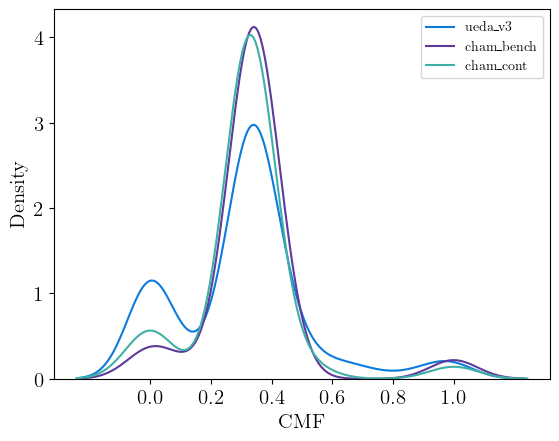

In [13]:
sns.kdeplot(ueda_v3_pldf['cmf'], color = colors[0], label = 'ueda_v3')
sns.kdeplot(cham_bench_pldf['cmf'], color = colors[4], linestyle='-', label = 'cham_bench')
sns.kdeplot(cham_cont_pldf['cmf'], color = colors[2], linestyle='-', label = 'cham_cont')
plt.legend()
ticks = np.linspace(0, 1, 6)
plt.xticks(ticks)
plt.xlabel("CMF")

plt.show()

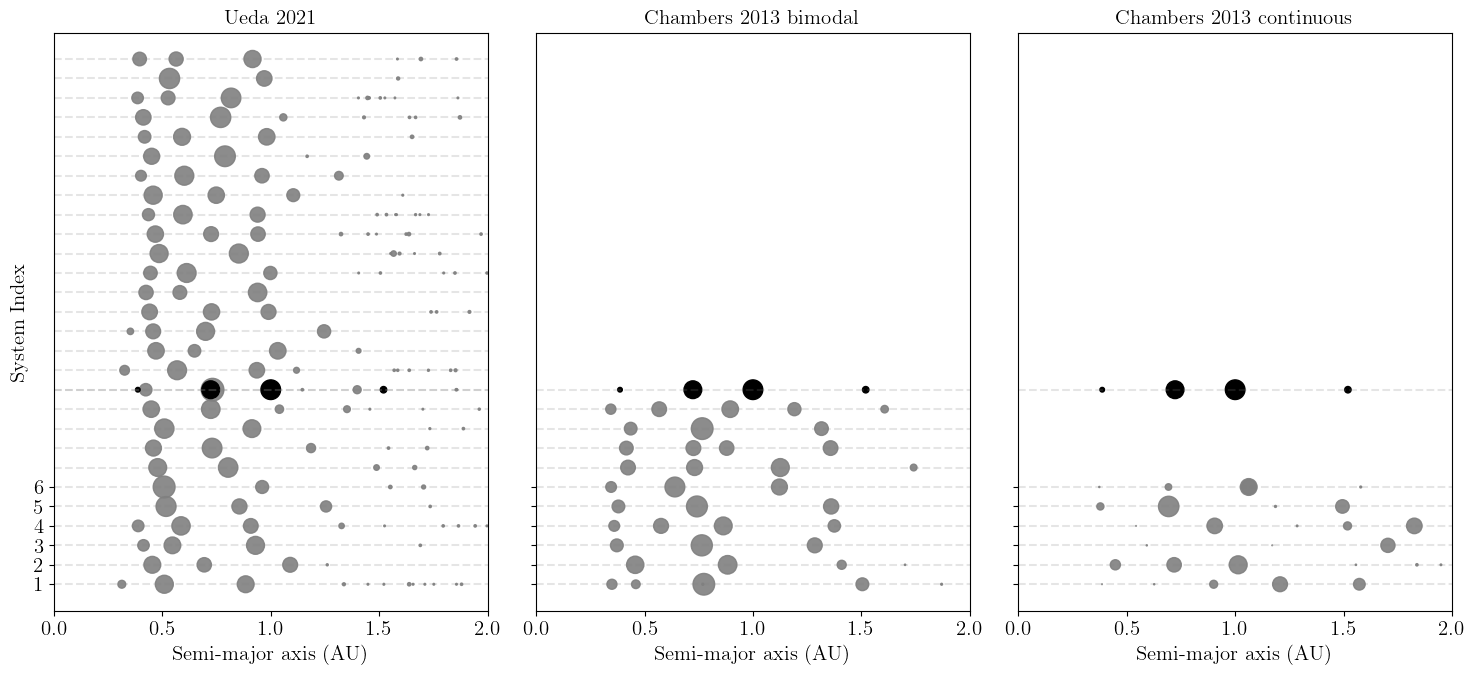

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharex=True, sharey=True)
axes = axes.flatten() # Ensures axes is a 1D array for easy iteration

# Solar System Data
solar_system_semis = [0.387, 0.723, 1, 1.52]  # AU for Mercury, Venus, Earth, Mars
solar_system_masses = [0.0553, 0.815, 1, 0.107] # Earth Masses

# Index for the Solar System
solar_system_index = 10 + 1 # This will be 11

datasets_to_plot = [
    ("Ueda 2021", ueda_v3_pldf_list),
    ("Chambers 2013 bimodal", cham_bench_pldf_list[:10]),
    ("Chambers 2013 continuous", cham_cont_pldf_list)
]

# A multiplier for scatter point size to make masses visible
# Adjust this based on the typical range of your 'mass' values
mass_size_multiplier = 200

for ax_idx, (title, pldf_list) in enumerate(datasets_to_plot):
    ax = axes[ax_idx]

    # Plot each planetary system (DataFrame)
    for system_idx, df in enumerate(pldf_list):
        ax.scatter(
            df['semi'],           # X-axis: Semi-major axis
            np.full(len(df), system_idx + 1), # Y-axis: Simulation/System Index (1 to 10)
            s=df['mass'] * sol_to_earth * mass_size_multiplier, # Size based on mass
            alpha=0.9, # Add some transparency
            color = 'gray'
        )
        # Optional: Add a horizontal line for each system for clarity
        ax.axhline(y=system_idx + 1, color='grey', linestyle='--', alpha=0.2)

    ax.scatter(
        solar_system_semis,
        np.full(len(solar_system_semis), solar_system_index),
        s=np.array(solar_system_masses) * 200, # Use a larger multiplier for solar system masses
        color='black'
    )
    ax.axhline(y=11, color='grey', linestyle='--', alpha=0.2)

    ax.set_title(title)
    ax.set_xlabel("Semi-major axis (AU)")

    # Set common Y-axis label only for the first subplot
    if ax_idx == 0:
        ax.set_ylabel("System Index")

    # Set Y-axis limits to clearly show 10 systems
    #ax.set_ylim(0.5, len(pldf_list) + 0.5)
    ax.set_yticks(np.arange(1, len(pldf_list) + 1)) # Set integer ticks for system indices

    # Optional: Set X-axis limits based on expected 'semi' range
    ax.set_xlim(0, 2.0)

plt.tight_layout()
plt.show()

In [15]:
ueda_v3_ppdf = pd.concat(ueda_v3_ppdf_list)
cham_bench_ppdf = pd.concat(cham_bench_ppdf_list)
cham_cont_ppdf = pd.concat(cham_cont_ppdf_list)

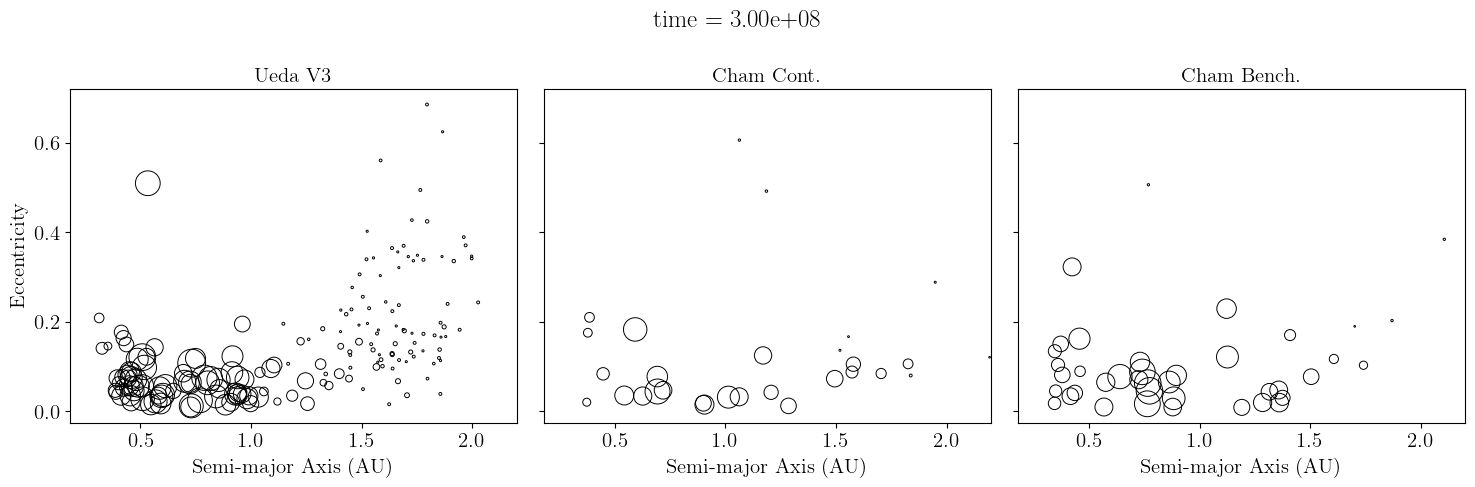

In [16]:
scale = 300
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

datasets_ecc = [
    ('Ueda V3', ueda_v3_ppdf),
    ('Cham Cont.', cham_cont_ppdf),
    ('Cham Bench.', cham_bench_ppdf),
]

for ax, (title, df) in zip(axes, datasets_ecc):
    ax.scatter(df['semi'], df['ecc'],
               s=df['mass'] * sol_to_earth * scale,
               edgecolors='k', facecolors='none', linewidths=0.7)
    
    ax.set_xlim(0.18, 2.2)
    ax.set_title(title)
    ax.set_xlabel('Semi-major Axis (AU)')

axes[0].set_ylabel('Eccentricity')
fig.suptitle(f'time = {cut_time:.2e}')
plt.tight_layout()
plt.show()


/var/folders/g0/fl404sj151l2v9xcdkjz9fq80000gn/T/ipykernel_90739/233828605.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/honeyeah/miniconda3/envs/haniyeh_research/lib/python3.13/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecate

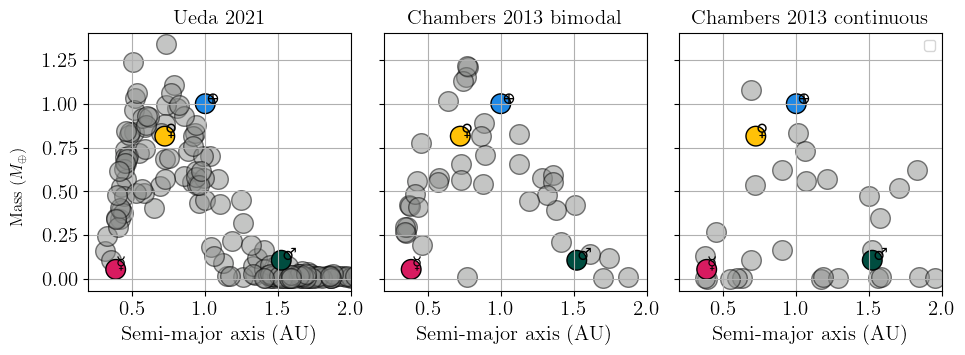

time = 3.00e+08 yrs


In [17]:
fig, axes = plt.subplots(1,3, figsize=(10, 4), sharey=True, sharex=True)
point_size = 200

for ax, (label, df, color) in zip(axes.flat, datasets):
    ax.scatter(df['semi'], df['mass'] * sol_to_earth, alpha=0.5, color=color, edgecolors='black', linewidths=1, s = point_size)

    # Add solar system planets
    ax.scatter(solar_system_df['a'], solar_system_df['m'], color = solar_system_df['color'], edgecolors='black', linewidths=1, s = point_size)
    ax.annotate('☿', [mercury['a'], mercury['m']], fontsize=12, usetex=False)
    ax.annotate('♀', [venus['a'], venus['m']], fontsize=12, usetex=False)
    ax.annotate('⊕', [earth['a'], earth['m']], fontsize=12, usetex=False)
    ax.annotate('♂', [mars['a'], mars['m']], fontsize=12, usetex=False)

    #ax.plot([0.001, 10], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5, label = 'CMF = 0.33')

    
    #ax.set_yscale('log')
    ax.set_xlabel('Semi-major axis (AU)')

    ax.set_xlim(0.2, 2)
    ax.grid(True)
    ax.set_title(label)
    

# Shared axis labels
ax.legend()
fig.text(0.04, 0.5, r'Mass ($M_\oplus$)', va='center', rotation='vertical', fontsize=12)

#fig.suptitle('Uniform CMF distributions (0.33)')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

plt.savefig("paper_plots/m_a.pdf", dpi=300)  # or .png

plt.show()

print(f"time = {cut_time:.2e} yrs")
#print("mean max time reached for Ueda v1 = ", np.average(maxtimes_ueda_v1)/1e6, "Myrs")
#print("mean max time reached for Cham = ", np.average(maxtimes_cham_bench)/1e6, "Myrs")

# Single plots

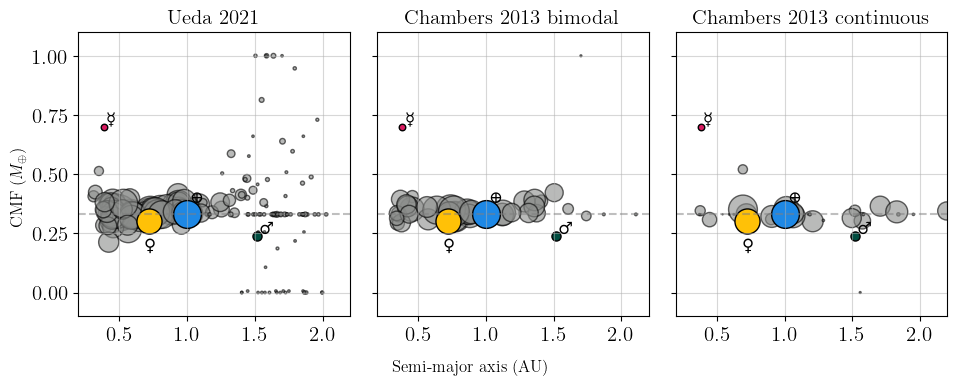

time = 3.00e+08 yrs


In [18]:
ueda_v3_pldf = pd.concat(ueda_v3_pldf_list)
cham_bench_pldf = pd.concat(cham_bench_pldf_list)
cham_cont_pldf = pd.concat(cham_cont_pldf_list)

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, sharex=True)

# Plot configs
datasets = [
    ("Ueda 2021", ueda_v3_pldf, colors[3]),
    ("Chambers 2013 bimodal", cham_bench_pldf, colors[3]),
    ("Chambers 2013 continuous", cham_cont_pldf, colors[3])
]

dot_scale = 400

for ax, (label, df, color) in zip(axes.flat, datasets):
    ax.grid(True, alpha = 0.5)
    ax.plot([0.2, 2.2], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5)

    ax.scatter(df['semi'], df['cmf'], alpha=0.6, color=color,
               edgecolors='black', linewidths=1, s = df['mass'] * sol_to_earth * dot_scale)

    # Add Mercury & Earth
    ax.scatter(0.387, 0.7, color='#D81B60', edgecolors='black', linewidths=1, s= 0.055 * dot_scale, label = 'Mercury')
    ax.annotate('☿', [0.4, 0.71], fontsize=12, usetex=False)

    ax.scatter(0.723, 0.3, color='#FFC107', edgecolors='black', linewidths=1, s=0.815 * dot_scale, label = 'Venus')
    ax.annotate('♀', [0.68, 0.18], fontsize=12, usetex=False)

    ax.scatter(1, 0.33, color='#1E88E5', edgecolors='black', linewidths=1, s=dot_scale, label = 'Earth')
    ax.annotate('⊕', [1.02, 0.38], fontsize=12, usetex=False)

    ax.scatter(1.52, 0.24, color='#004D40', edgecolors='black', linewidths=1, s=0.107 * dot_scale, label = 'Mars')
    ax.annotate('♂', [1.53, 0.25], fontsize=12, usetex=False)

   
    # Reference lines
    #ax.plot([0.35, 2], [0.3, 0.3], linestyle='dashed', color='grey', alpha=0.5)
    #ax.plot([0.35, 0.35], [0.01, 1.2], linestyle='dashed', color='grey', alpha=0.5)
    #ax.plot([0.7, 0.7], [0.01, 1.2], linestyle='dashed', color='grey', alpha=0.5)

    ax.set_xlim(0.2, 2.2)
    ax.set_ylim(-0.1,1.1)
    ax.set_title(label)

#ax.legend(loc = 'upper right')

# Shared axis labels
fig.text(0.5, 0.04, 'Semi-major axis (AU)', ha='center', fontsize=12)
fig.text(0.04, 0.5, r'CMF ($M_\oplus$)', va='center', rotation='vertical', fontsize=12)

#fig.suptitle('Uniform CMF distributions (0.33)')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

plt.savefig("paper_plots/uniform_cmf_dists.pdf", dpi=300)  # or .png

plt.show()

print(f"time = {cut_time:.2e} yrs")
#print("mean max time reached for Ueda v1 = ", np.average(maxtimes_ueda_v1)/1e6, "Myrs")
#print("mean max time reached for Cham = ", np.average(maxtimes_cham_bench)/1e6, "Myrs")

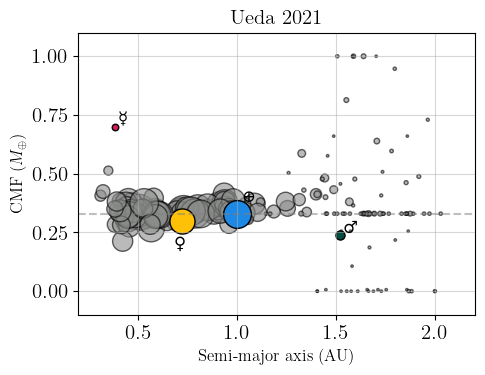

time = 3.00e+08 yrs


In [19]:
fig, ax = plt.subplots(figsize=(5, 4))

dot_scale = 400
color = colors[3]

ax.grid(True, alpha=0.5)
ax.plot([0.2, 2.2], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5)

# Scatter for Ueda 2021 data
ax.scatter(
    ueda_v3_pldf['semi'], ueda_v3_pldf['cmf'],
    alpha=0.6, color=color, edgecolors='black', linewidths=1,
    s=ueda_v3_pldf['mass'] * sol_to_earth * dot_scale
)

# Add Mercury
ax.scatter(0.387, 0.7, color='#D81B60', edgecolors='black', linewidths=1, s=0.055 * dot_scale, label='Mercury')
ax.annotate('☿', [0.4, 0.71], fontsize=12, usetex=False)

# Add Venus
ax.scatter(0.723, 0.3, color='#FFC107', edgecolors='black', linewidths=1, s=0.815 * dot_scale, label='Venus')
ax.annotate('♀', [0.68, 0.18], fontsize=12, usetex=False)

# Add Earth
ax.scatter(1, 0.33, color='#1E88E5', edgecolors='black', linewidths=1, s=dot_scale, label='Earth')
ax.annotate('⊕', [1.02, 0.38], fontsize=12, usetex=False)

# Add Mars
ax.scatter(1.52, 0.24, color='#004D40', edgecolors='black', linewidths=1, s=0.107 * dot_scale, label='Mars')
ax.annotate('♂', [1.53, 0.25], fontsize=12, usetex=False)

# Axis limits & labels
ax.set_xlim(0.2, 2.2)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('Semi-major axis (AU)', fontsize=12)
ax.set_ylabel(r'CMF ($M_\oplus$)', fontsize=12)
ax.set_title("Ueda 2021")

plt.tight_layout()
plt.savefig("paper_plots/ueda_v3_single.pdf", dpi=300)
plt.show()

print(f"time = {cut_time:.2e} yrs")


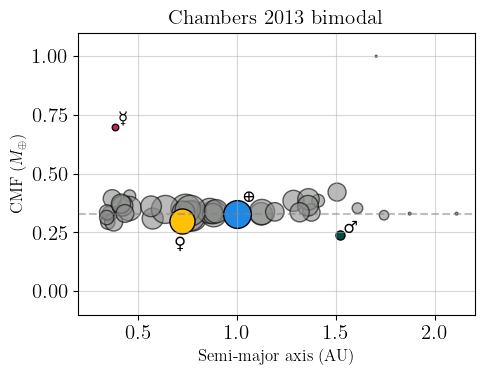

time = 3.00e+08 yrs


In [20]:
fig, ax = plt.subplots(figsize=(5, 4))

dot_scale = 400
color = colors[3]

ax.grid(True, alpha=0.5)
ax.plot([0.2, 2.2], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5)

# Scatter for Ueda 2021 data
ax.scatter(
    cham_bench_pldf['semi'], cham_bench_pldf['cmf'],
    alpha=0.6, color=color, edgecolors='black', linewidths=1,
    s=cham_bench_pldf['mass'] * sol_to_earth * dot_scale
)

# Add Mercury
ax.scatter(0.387, 0.7, color='#D81B60', edgecolors='black', linewidths=1, s=0.055 * dot_scale, label='Mercury')
ax.annotate('☿', [0.4, 0.71], fontsize=12, usetex=False)

# Add Venus
ax.scatter(0.723, 0.3, color='#FFC107', edgecolors='black', linewidths=1, s=0.815 * dot_scale, label='Venus')
ax.annotate('♀', [0.68, 0.18], fontsize=12, usetex=False)

# Add Earth
ax.scatter(1, 0.33, color='#1E88E5', edgecolors='black', linewidths=1, s=dot_scale, label='Earth')
ax.annotate('⊕', [1.02, 0.38], fontsize=12, usetex=False)

# Add Mars
ax.scatter(1.52, 0.24, color='#004D40', edgecolors='black', linewidths=1, s=0.107 * dot_scale, label='Mars')
ax.annotate('♂', [1.53, 0.25], fontsize=12, usetex=False)

# Axis limits & labels
ax.set_xlim(0.2, 2.2)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('Semi-major axis (AU)', fontsize=12)
ax.set_ylabel(r'CMF ($M_\oplus$)', fontsize=12)
ax.set_title("Chambers 2013 bimodal")

plt.tight_layout()
plt.savefig("paper_plots/cham_bench_single.pdf", dpi=300)
plt.show()

print(f"time = {cut_time:.2e} yrs")


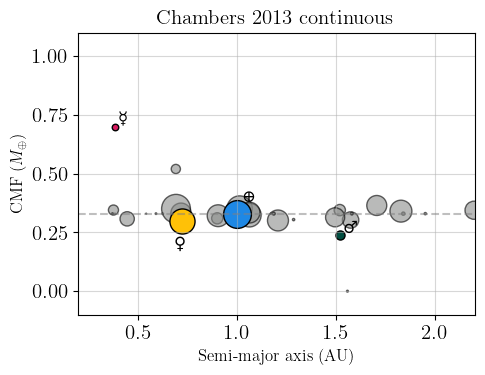

time = 3.00e+08 yrs


In [21]:
fig, ax = plt.subplots(figsize=(5, 4))

dot_scale = 400
color = colors[3]

ax.grid(True, alpha=0.5)
ax.plot([0.2, 2.2], [0.33, 0.33], linestyle='dashed', color='grey', alpha=0.5)

# Scatter for Ueda 2021 data
ax.scatter(
    cham_cont_pldf['semi'], cham_cont_pldf['cmf'],
    alpha=0.6, color=color, edgecolors='black', linewidths=1,
    s=cham_cont_pldf['mass'] * sol_to_earth * dot_scale
)

# Add Mercury
ax.scatter(0.387, 0.7, color='#D81B60', edgecolors='black', linewidths=1, s=0.055 * dot_scale, label='Mercury')
ax.annotate('☿', [0.4, 0.71], fontsize=12, usetex=False)

# Add Venus
ax.scatter(0.723, 0.3, color='#FFC107', edgecolors='black', linewidths=1, s=0.815 * dot_scale, label='Venus')
ax.annotate('♀', [0.68, 0.18], fontsize=12, usetex=False)

# Add Earth
ax.scatter(1, 0.33, color='#1E88E5', edgecolors='black', linewidths=1, s=dot_scale, label='Earth')
ax.annotate('⊕', [1.02, 0.38], fontsize=12, usetex=False)

# Add Mars
ax.scatter(1.52, 0.24, color='#004D40', edgecolors='black', linewidths=1, s=0.107 * dot_scale, label='Mars')
ax.annotate('♂', [1.53, 0.25], fontsize=12, usetex=False)

# Axis limits & labels
ax.set_xlim(0.2, 2.2)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel('Semi-major axis (AU)', fontsize=12)
ax.set_ylabel(r'CMF ($M_\oplus$)', fontsize=12)
ax.set_title("Chambers 2013 continuous")

plt.tight_layout()
plt.savefig("paper_plots/cham_cont_single.pdf", dpi=300)
plt.show()

print(f"time = {cut_time:.2e} yrs")
